In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mywork/Copy of Combined_df.csv
/kaggle/input/capstone-top10/o_hypertension_quantity_per_capita_top_features.csv
/kaggle/input/capstone-top10/o_total_quantity_per_capita_top_features.csv
/kaggle/input/capstone-top10/o_opioids_quantity_per_capita_top_features.csv
/kaggle/input/capstone-top10/o_depression_quantity_per_capita_top_features.csv
/kaggle/input/capstone-top10/o_anxiety_quantity_per_capita_top_features.csv
/kaggle/input/capstone-top10/o_diabetes_quantity_per_capita_top_features.csv
/kaggle/input/capstone-top10/o_asthma_quantity_per_capita_top_features.csv
/kaggle/input/capstone-geojson/2019_spatial_raw_master.geojson
/kaggle/input/capstone-geojson/2020_spatial_raw_master.geojson


In [2]:
import shap
import numpy as np
import pandas as pd
import glob
import os
import geopandas as gpd
from patsy import bs
import statsmodels.formula.api as smf
from patsy import bs, EvalEnvironment
from patsy.builtins import Q
import re

import warnings
warnings.filterwarnings('ignore')

In [4]:
chunk_size = 5000
#df_chunks = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Combined_df.csv", chunksize=chunk_size)
#df_chunks = pd.read_csv(r"\Users\gnane\Downloads\Copy of Combined_df.csv", chunksize=chunk_size)
df_chunks = pd.read_csv("/kaggle/input/mywork/Copy of Combined_df.csv", chunksize=chunk_size)
df = pd.concat(chunk for chunk in df_chunks)

In [5]:
data = gpd.read_file('/kaggle/input/capstone-geojson/2019_spatial_raw_master.geojson')
data.set_index('geography code', inplace=True)
data1 = gpd.read_file('/kaggle/input/capstone-geojson/2020_spatial_raw_master.geojson')
data1.set_index('geography code', inplace=True)
# Concatenate the two GeoDataFrames
df_geo = pd.concat([data, data1])

In [6]:
medical_outcomes = ['o_diabetes_quantity_per_capita', 'o_hypertension_quantity_per_capita','o_asthma_quantity_per_capita', 'o_depression_quantity_per_capita','o_anxiety_quantity_per_capita', 'o_opioids_quantity_per_capita','o_total_quantity_per_capita']

In [7]:
# Example: "City of London 001A" -> "City of London"
#          "Barking and Dagenham 016A" -> "Barking and Dagenham"

df['lad_name'] = df['lsoa21nm'].apply(lambda x: x.rsplit(' ', 1)[0])
print(df[['lsoa21nm', 'lad_name']])

                        lsoa21nm              lad_name
0            City of London 001A        City of London
1            City of London 001B        City of London
2            City of London 001C        City of London
3            City of London 001E        City of London
4      Barking and Dagenham 016A  Barking and Dagenham
...                          ...                   ...
67503   Vale of White Horse 014H   Vale of White Horse
67504   Vale of White Horse 015G   Vale of White Horse
67505   Vale of White Horse 015H   Vale of White Horse
67506   Vale of White Horse 015I   Vale of White Horse
67507      West Oxfordshire 004H      West Oxfordshire

[67508 rows x 2 columns]


In [8]:
csv_dir = "/kaggle/input/capstone-top10"
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))  # e.g., 'diabetes_top10.csv'
top_predictors = {}

In [9]:
for csv_file in csv_files:
    # Extract outcome name from filename (e.g., 'diabetes' from 'diabetes_top10.csv')
    outcome = os.path.basename(csv_file).replace('_top_features.csv', '')
    if outcome not in df.columns:
        print(f"Warning: Outcome '{outcome_col}' not found in dataset. Skipping.")
        continue
    df_csv = pd.read_csv(csv_file)
    predictors = df_csv["Unnamed: 0"].head(10).tolist()  # Assumes column 'Predictor'
    # Verify predictors exist in dataset
    predictors = [p for p in predictors if p in df.columns]
    if not predictors:
        print(f"Warning: No valid predictors found for {outcome}. Skipping.")
        continue
    top_predictors[outcome] = predictors
    print(f"Top predictors for {outcome}: {predictors}")

Top predictors for o_hypertension_quantity_per_capita: ['c_percent_white', 'e_surface_solar_radiation_downwards_sum', 'c_percent_commute_bus', 'e_surface_thermal_radiation_downwards_sum', 'e_snow_density', 'e_lake_mix_layer_temperature', 'e_evaporation_from_the_top_of_canopy_sum', 'e_surface_net_solar_radiation_sum', 'e_evaporation_from_open_water_surfaces_excluding_oceans_sum', 'c_percent_married_or_in_a_registered_civil_partnership']
Top predictors for o_total_quantity_per_capita: ['c_percent_10_years_or_more', 'c_percent_wfh', 'e_surface_thermal_radiation_downwards_sum', 'e_no2', 'c_percent_commute_bicycle', 'c_percent_commute_bus', 'e_evaporation_from_the_top_of_canopy_sum', 'e_lake_mix_layer_temperature', 'e_temperature_2m', 'e_surface_runoff_sum']
Top predictors for o_opioids_quantity_per_capita: ['c_net_annual_income', 'c_percent_2._professional_occupations', 'e_surface_thermal_radiation_downwards_sum', 'c_percent_mixed', 'c_percent_commute_metro_rail', 'e_no2', 'e_lake_mix_laye

In [10]:
# Collect all unique predictors
all_predictors = set()
for predictors in top_predictors.values():
    all_predictors.update(predictors)
all_predictors = list(all_predictors)
print(f"Total unique predictors: {len(all_predictors)}")

Total unique predictors: 33


In [11]:
# Suppose you already have 'selected_features' (after correlation filtering)
# and 'medical_outcomes' from your earlier analysis.

agg_columns = all_predictors + medical_outcomes

df_lad = (
    df.groupby('lad_name')[agg_columns]
      .mean()  # Or .median(), if that suits your data better
      .reset_index()
)

print("Aggregated LAD-level data shape:", df_lad.shape)
print(df_lad.head())

Aggregated LAD-level data shape: (309, 41)
       lad_name  c_percent_white  e_lake_mix_layer_depth  \
0          Adur         0.934383               11.038455   
1     Allerdale         0.984342               13.080173   
2  Amber Valley         0.973047               21.181422   
3          Arun         0.959056               10.974335   
4      Ashfield         0.952828               21.258174   

   c_percent___can_speak_english_very_well  e_leaf_area_index_high_vegetation  \
0                                 0.015959                           2.156510   
1                                 0.005581                           2.386602   
2                                 0.006577                           1.971895   
3                                 0.021578                           2.148655   
4                                 0.013212                           2.187852   

   c_percent_married_or_in_a_registered_civil_partnership  \
0                                           0.45

In [12]:
# Create the same lad_name column in your GeoDataFrame
df_geo['lad_name'] = df_geo['LSOA21NM'].apply(lambda x: x.rsplit(' ', 1)[0])

# Dissolve by lad_name to get one polygon per LAD
lad_geometries = df_geo.dissolve(by='lad_name')

# Compute centroids
lad_geometries['centroid'] = lad_geometries.geometry.centroid
lad_geometries['centroid_x'] = lad_geometries['centroid'].x
lad_geometries['centroid_y'] = lad_geometries['centroid'].y

# Merge these centroid coordinates back into the aggregated df_lad
df_lad = df_lad.merge(
    lad_geometries[['centroid_x', 'centroid_y']],
    on='lad_name',  # Merges on the lad_name column
    how='left'
)

In [13]:
df_lad.head(2)

,lad_name,c_percent_white,e_lake_mix_layer_depth,c_percent___can_speak_english_very_well,e_leaf_area_index_high_vegetation,c_percent_married_or_in_a_registered_civil_partnership,c_percent_2._professional_occupations,c_percent_student_moved_to_address,e_surface_thermal_radiation_downwards_sum,e_surface_solar_radiation_downwards_sum,...,e_no2,o_diabetes_quantity_per_capita,o_hypertension_quantity_per_capita,o_asthma_quantity_per_capita,o_depression_quantity_per_capita,o_anxiety_quantity_per_capita,o_opioids_quantity_per_capita,o_total_quantity_per_capita,centroid_x,centroid_y
0,Adur,0.934383,11.038455,0.015959,2.156510,0.457504,0.177747,0.001513,8.306324e+08,2.500392e+07,...,0.000098,35.219350,90.354576,12.892678,38.771795,48.131123,31.618506,1029.308259,519832.891078,106424.943881
1,Allerdale,0.984342,13.080173,0.005581,2.386602,0.481619,0.156510,0.001302,8.258235e+08,2.770894e+08,...,0.000068,40.629214,111.422969,14.896261,41.320104,52.968730,40.982229,1281.491911,320062.312420,534980.812530


In [14]:
lad_geometries.head(2)

,geometry,LSOA21NM,centroid_x,centroid_y,c_percent asian,c_percent black,c_percent mixed,c_percent white,c_percent sikh,c_percent hindu,...,e_snow_and_ice,o_diabetes_quantity_per_capita,o_opioids_quantity_per_capita,o_OME_per_capita,o_total_quantity_per_capita,o_asthma_quantity_per_capita,o_hypertension_quantity_per_capita,o_depression_quantity_per_capita,o_anxiety_quantity_per_capita,centroid
lad_name,,,,,,,,,,,,,,,,,,,,,
Adur,"MULTIPOLYGON (((518163.049 103556.691, 518151....",Adur 002A,519832.891078,106424.943881,0.020801,0.002311,0.030046,0.934515,0.000773,0.000000,...,0.040419,17.366574,19.094030,199.618089,564.413376,6.807405,48.578173,19.829621,25.559192,POINT (519832.891 106424.944)
Allerdale,"MULTIPOLYGON (((298682.700 525222.350, 298820....",Allerdale 007A,320062.312420,534980.812530,0.008368,0.001395,0.008368,0.981869,0.000696,0.002786,...,0.040593,41.120013,37.820984,269.443658,1644.572451,17.086636,131.005476,42.455040,51.946084,POINT (320062.312 534980.813)


In [15]:
def filter_predictors(predictor_list, df, corr_threshold=0.8):

    selected = []
    for predictor in predictor_list:
        add_predictor = True
        for sel in selected:
            corr_value = df[[predictor, sel]].corr().iloc[0, 1]
            if abs(corr_value) > corr_threshold:
                add_predictor = False
                # Predictor appearing later in ranked order is dropped
                break
        if add_predictor:
            selected.append(predictor)
    return selected

In [16]:
def quote_if_needed(var):
    return f'Q("{var}")' if not re.match(r'^[A-Za-z_][A-Za-z0-9_]*$', var) else var

In [17]:
gam_models = {}  # to store fitted models
selected_predictors_dict = {}  # to store selected predictors per outcome
for outcome in medical_outcomes:
    all_predictors = top_predictors.get(outcome, [])
    predictors_in_data = [var for var in all_predictors if var in df_lad.columns]
    selected_predictors = filter_predictors(predictors_in_data, df_lad, corr_threshold=0.8)
    selected_predictors_dict[outcome] = selected_predictors

    # Quote predictors and outcome where needed
    quoted_outcome = quote_if_needed(outcome)
    quoted_predictors = [quote_if_needed(pred) for pred in selected_predictors]

    # Construct the formula
    formula = (
        f"{quoted_outcome} ~ "
        + " + ".join(quoted_predictors)
        + " + bs(centroid_x, df=5) * bs(centroid_y, df=5)"
    )

    print("\n======================================")
    print(f"Fitting GAM for outcome: {outcome}")
    print("Using predictors:", selected_predictors)
    print("Formula:", formula)
    print("======================================\n")

    # Fit the model
    gam_model = smf.ols(formula=formula, data=df_lad, eval_env=EvalEnvironment.capture(1)).fit()
    gam_models[outcome] = gam_model

    print(gam_model.summary())
    df_lad[f"{outcome}_pred"] = gam_model.predict(df_lad)


Fitting GAM for outcome: o_diabetes_quantity_per_capita
Using predictors: ['e_leaf_area_index_low_vegetation', 'c_net_annual_income', 'c_percent_8._process_plant_and_machine_operatives', 'c_percent_commute_bus', 'c_percent_commute_bicycle', 'c_percent_student_moved_to_address', 'e_lake_mix_layer_depth', 'c_percent_tfw_2km_to_5km', 'c_percent_5._skilled_trades_occupations', 'c_percent_asian']
Formula: o_diabetes_quantity_per_capita ~ e_leaf_area_index_low_vegetation + c_net_annual_income + Q("c_percent_8._process_plant_and_machine_operatives") + c_percent_commute_bus + c_percent_commute_bicycle + c_percent_student_moved_to_address + e_lake_mix_layer_depth + c_percent_tfw_2km_to_5km + Q("c_percent_5._skilled_trades_occupations") + c_percent_asian + bs(centroid_x, df=5) * bs(centroid_y, df=5)

                                  OLS Regression Results                                  
Dep. Variable:     o_diabetes_quantity_per_capita   R-squared:                       0.603
Model:         

In [18]:
df_lad[f"{outcome}_pred"] = gam_model.predict(df_lad)
output_path = f'/kaggle/working/df_lad_with_gam_predictions.csv'
df_lad.to_csv(output_path)

In [19]:
!pip install mgwr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 10.7 MB/s eta 0:00:0000:01


In [20]:
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
import numpy as np

# Outcomes list
medical_outcomes = [
    'o_diabetes_quantity_per_capita',
    'o_hypertension_quantity_per_capita',
    'o_asthma_quantity_per_capita',
    'o_depression_quantity_per_capita',
    'o_anxiety_quantity_per_capita',
    'o_opioids_quantity_per_capita',
    'o_total_quantity_per_capita'
]

# Dictionary to store MGWR models
mgwr_models = {}


In [21]:
for outcome in medical_outcomes:
    print(f"\nProcessing MGWR for: {outcome}")

    # Get selected predictors (already filtered for multicollinearity)
    predictors = selected_predictors_dict.get(outcome, [])
    
    if not predictors:
        print(f"No predictors found for {outcome}, skipping.")
        continue

    # Extract and scale predictors
    X_mgwr = df_lad[predictors].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_mgwr)

    # Target variable
    y = df_lad[outcome].values.reshape(-1, 1)

    # Coordinates
    coords = df_lad[['centroid_x', 'centroid_y']].values

    # Bandwidth selection
    mgwr_selector = Sel_BW(coords, y, X_scaled, multi=True)
    bw = mgwr_selector.search()
    print(f"Bandwidths selected for {outcome}: {bw}")

    # Fit MGWR model
    mgwr_model = MGWR(coords, y, X_scaled, selector=mgwr_selector)
    mgwr_results = mgwr_model.fit()
    mgwr_models[outcome] = mgwr_model

    # Store coefficients
    mgwr_betas = mgwr_results.params
    df_lad[f'{outcome}_mgwr_intercept'] = mgwr_betas[:, 0]
    for i, col in enumerate(predictors):
        df_lad[f'{outcome}_mgwr_{col}'] = mgwr_betas[:, i + 1]

    # Print coefficient variability
    coef_stds = np.std(mgwr_betas, axis=0)
    print("Coefficient variability (std dev):")
    print(f"  Intercept: {coef_stds[0]:.4f}")
    for i, col in enumerate(predictors):
        print(f"  {col}: {coef_stds[i + 1]:.4f}")



Processing MGWR for: o_diabetes_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_diabetes_quantity_per_capita: [ 82. 246.  73. 138. 123.  82. 231. 308. 275. 228. 184.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 3.5658
  e_leaf_area_index_low_vegetation: 0.5422
  c_net_annual_income: 4.1072
  c_percent_8._process_plant_and_machine_operatives: 1.3456
  c_percent_commute_bus: 2.3627
  c_percent_commute_bicycle: 1.6578
  c_percent_student_moved_to_address: 0.7771
  e_lake_mix_layer_depth: 0.1525
  c_percent_tfw_2km_to_5km: 0.3421
  c_percent_5._skilled_trades_occupations: 1.7264
  c_percent_asian: 1.5070

Processing MGWR for: o_hypertension_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_hypertension_quantity_per_capita: [308. 246. 246. 120.  43. 234. 308. 121. 144.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 0.2888
  c_percent_white: 2.3887
  e_surface_solar_radiation_downwards_sum: 1.8919
  c_percent_commute_bus: 7.4104
  e_surface_thermal_radiation_downwards_sum: 14.8333
  e_snow_density: 5.8224
  e_evaporation_from_the_top_of_canopy_sum: 0.2201
  e_evaporation_from_open_water_surfaces_excluding_oceans_sum: 2.4867
  c_percent_married_or_in_a_registered_civil_partnership: 6.6074

Processing MGWR for: o_asthma_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_asthma_quantity_per_capita: [207.  65. 271. 185. 308. 138. 234. 308.  43.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 0.4446
  c_net_annual_income: 1.4095
  c_percent_commute_car: 0.1354
  c_percent_commute_bus: 0.4073
  e_leaf_area_index_high_vegetation: 0.0300
  c_percent_tfw_2km_to_5km: 0.2130
  e_lake_mix_layer_depth: 0.2618
  e_no2: 0.0368
  c_percent_commute_metro_rail: 2.6298

Processing MGWR for: o_depression_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_depression_quantity_per_capita: [157. 139.  66. 308. 123. 308. 247.  69. 103. 308. 207.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 2.7258
  c_net_annual_income: 2.8689
  c_percent_no_religion: 3.2357
  c_percent_asian: 0.0505
  c_percent_commute_bus: 1.5739
  c_percent_mixed: 0.0366
  e_leaf_area_index_low_vegetation: 0.6894
  e_surface_thermal_radiation_downwards_sum: 1.7587
  c_percent_commute_bicycle: 1.9486
  e_lake_mix_layer_depth: 0.0907
  e_no2: 1.3805

Processing MGWR for: o_anxiety_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_anxiety_quantity_per_capita: [ 72. 183. 247. 183.  81.  69. 145. 302. 120.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 5.0703
  c_net_annual_income: 3.4304
  c_percent_10_years_or_more: 1.0343
  e_leaf_area_index_low_vegetation: 1.8696
  c_percent_commute_bicycle: 2.5200
  e_surface_thermal_radiation_downwards_sum: 2.8200
  c_percent_tfw_less_than_2km: 1.0457
  e_lake_mix_layer_depth: 0.2768
  c_percent_commute_bus: 3.3065

Processing MGWR for: o_opioids_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_opioids_quantity_per_capita: [308.  45. 132.  69.  44. 307.  44. 308.  74. 308.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 0.1346
  c_net_annual_income: 3.3737
  c_percent_2._professional_occupations: 1.2569
  e_surface_thermal_radiation_downwards_sum: 3.4529
  c_percent_mixed: 4.6721
  c_percent_commute_metro_rail: 0.0645
  e_no2: 4.6101
  e_lake_mix_layer_depth: 0.0828
  e_total_aerosol_optical_depth_at_550nm_surface: 1.5290
  e_evaporation_from_the_top_of_canopy_sum: 0.0847

Processing MGWR for: o_total_quantity_per_capita


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Bandwidths selected for o_total_quantity_per_capita: [160. 308.  54.  65. 137. 121. 308. 144. 308.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coefficient variability (std dev):
  Intercept: 33.3738
  c_percent_10_years_or_more: 2.0760
  c_percent_wfh: 82.5251
  e_surface_thermal_radiation_downwards_sum: 149.1831
  c_percent_commute_bicycle: 46.4726
  c_percent_commute_bus: 38.2861
  e_evaporation_from_the_top_of_canopy_sum: 7.1022
  e_lake_mix_layer_temperature: 34.5271
  e_surface_runoff_sum: 0.7579


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
# Extract all columns that hold MGWR coefficients
mgwr_cols = [col for col in df_lad.columns if '_mgwr_' in col]

# Drop rows with missing values just in case
mgwr_data = df_lad[mgwr_cols].dropna().copy()

# Keep LAD names for reference
lad_names = df_lad.loc[mgwr_data.index, 'lad_name'].values


In [25]:
scaler = StandardScaler()
mgwr_scaled = scaler.fit_transform(mgwr_data)


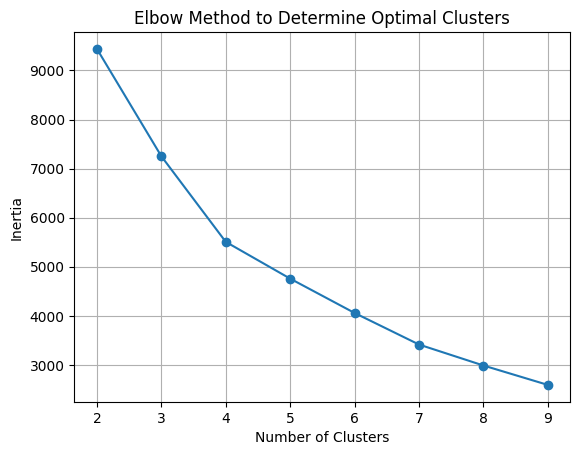

In [26]:
# Optional: Plot inertia to pick number of clusters
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mgwr_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 10), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.grid(True)
plt.show()


In [27]:
# Fit final KMeans model
k = 4  # you can adjust based on elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(mgwr_scaled)

# Add cluster labels back to df_lad
df_lad.loc[mgwr_data.index, 'mgwr_region'] = cluster_labels


In [28]:
# Check number of LADs in each region
df_lad['mgwr_region'].value_counts()

# Preview a few
df_lad[['lad_name', 'mgwr_region'] + mgwr_cols].head()


,lad_name,mgwr_region,o_diabetes_quantity_per_capita_mgwr_intercept,o_diabetes_quantity_per_capita_mgwr_e_leaf_area_index_low_vegetation,o_diabetes_quantity_per_capita_mgwr_c_net_annual_income,o_diabetes_quantity_per_capita_mgwr_c_percent_8._process_plant_and_machine_operatives,o_diabetes_quantity_per_capita_mgwr_c_percent_commute_bus,o_diabetes_quantity_per_capita_mgwr_c_percent_commute_bicycle,o_diabetes_quantity_per_capita_mgwr_c_percent_student_moved_to_address,o_diabetes_quantity_per_capita_mgwr_e_lake_mix_layer_depth,...,o_opioids_quantity_per_capita_mgwr_e_evaporation_from_the_top_of_canopy_sum,o_total_quantity_per_capita_mgwr_intercept,o_total_quantity_per_capita_mgwr_c_percent_10_years_or_more,o_total_quantity_per_capita_mgwr_c_percent_wfh,o_total_quantity_per_capita_mgwr_e_surface_thermal_radiation_downwards_sum,o_total_quantity_per_capita_mgwr_c_percent_commute_bicycle,o_total_quantity_per_capita_mgwr_c_percent_commute_bus,o_total_quantity_per_capita_mgwr_e_evaporation_from_the_top_of_canopy_sum,o_total_quantity_per_capita_mgwr_e_lake_mix_layer_temperature,o_total_quantity_per_capita_mgwr_e_surface_runoff_sum
0,Adur,0.0,41.669023,0.634895,2.031851,3.172632,0.459842,-1.251389,-1.894681,-0.237645,...,-0.625353,1196.863343,-96.586208,-96.133682,273.899930,-37.764023,-31.746094,-103.833135,-10.942854,-61.373754
1,Allerdale,3.0,32.564670,-0.732608,-7.046260,0.664092,-3.331531,-2.650402,-0.155731,0.199259,...,-0.437701,1110.932780,-103.886966,17.822863,-108.306811,-126.478435,-14.270405,-82.041728,35.706023,-61.271259
2,Amber Valley,2.0,35.336556,-0.627625,-9.045930,1.306974,-4.780502,-5.135158,-0.032423,0.031364,...,-0.474181,1118.798297,-98.557509,-228.683558,-81.365011,-128.937319,-111.803634,-90.260724,22.577872,-59.580060
3,Arun,0.0,42.275840,0.616611,2.183664,3.233891,0.434266,-0.497740,-1.939547,-0.248450,...,-0.632760,1195.492890,-96.473281,-107.077827,235.078444,-39.144847,-32.780575,-103.602577,-8.306809,-61.348339
4,Ashfield,2.0,35.555053,-0.642266,-9.132914,0.849901,-4.838535,-5.119792,0.074728,0.043722,...,-0.468917,1120.232504,-98.784975,-215.178522,-74.748829,-127.628184,-121.466330,-90.167436,23.308221,-59.715565
